<a href="https://colab.research.google.com/github/Antoine-Cohen/Python_Analysis_UAV_Detection/blob/main/Projet_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import des librairies

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Dataset 1 

## Recupération des données (.mat) sous un dataframe

In [ ]:
url = 'http://mason.gmu.edu/~lzhao9/materials/data/UAV/data/pub_dataset1.mat'
r = requests.get(url, allow_redirects=True)
open('pub_dataset1.mat', 'wb').write(r.content)

6268227

In [ ]:
import h5py
data_path = './pub_dataset1.mat'
with h5py.File(data_path, 'r') as f:
    data_tr = pd.DataFrame(data = f['data_tr']).T
    data_te = pd.DataFrame(data = f['data_te']).T

## Renommage des colonnes

In [ ]:
from bs4 import BeautifulSoup
url = 'https://archive.ics.uci.edu/ml/datasets/Unmanned+Aerial+Vehicle+%28UAV%29+Intrusion+Detection'
response = requests.get(url)
soup = BeautifulSoup(response.text,'html.parser')

In [ ]:
cat = soup.find_all('p',{'class':'normal'})[21] # Tous les noms des colonnes
cat

<p class="normal">The raw inputs are the radio frequency time series in two directions: uplink_flow and downlink_flow. Attributes are processed from the raw input, the list of attributes are:
<br/>1. uplink_size_mean
<br/>2. uplink_size_median
<br/>3. uplink_size_MAD
<br/>4. uplink_size_STD
<br/>5. uplink_size_Skewness
<br/>6. uplink_size_Kurtosis
<br/>7. uplink_size_MAX
<br/>8. uplink_size_MIN
<br/>9. uplink_size_MeanSquare
<br/>10. downlink_size_mean
<br/>11. downlink_size_median
<br/>12. downlink_size_MAD
<br/>13. downlink_size_STD
<br/>14. downlink_size_Skewness
<br/>15. downlink_size_Kurtosis
<br/>16. downlink_size_MAX
<br/>17. downlink_size_MIN
<br/>18. downlink_size_MeanSquare
<br/>19. both_links_size_mean
<br/>20. both_links_size_median
<br/>21. both_links_size_MAD
<br/>22. both_links_size_STD
<br/>23. both_links_size_Skewness
<br/>24. both_links_size_Kurtosis
<br/>25. both_links_size_MAX
<br/>26. both_links_size_MIN
<br/>27. both_links_size_MeanSquare
<br/>28. uplink_interval_

In [ ]:
cat = cat.get_text(separator = '<br/>',strip = True).split('<br/>')[1:] # Recup le texte propre
cat

['1. uplink_size_mean',
 '2. uplink_size_median',
 '3. uplink_size_MAD',
 '4. uplink_size_STD',
 '5. uplink_size_Skewness',
 '6. uplink_size_Kurtosis',
 '7. uplink_size_MAX',
 '8. uplink_size_MIN',
 '9. uplink_size_MeanSquare',
 '10. downlink_size_mean',
 '11. downlink_size_median',
 '12. downlink_size_MAD',
 '13. downlink_size_STD',
 '14. downlink_size_Skewness',
 '15. downlink_size_Kurtosis',
 '16. downlink_size_MAX',
 '17. downlink_size_MIN',
 '18. downlink_size_MeanSquare',
 '19. both_links_size_mean',
 '20. both_links_size_median',
 '21. both_links_size_MAD',
 '22. both_links_size_STD',
 '23. both_links_size_Skewness',
 '24. both_links_size_Kurtosis',
 '25. both_links_size_MAX',
 '26. both_links_size_MIN',
 '27. both_links_size_MeanSquare',
 '28. uplink_interval_mean',
 '29. uplink_interval_median',
 '30. uplink_interval_MAD',
 '31. uplink_interval_STD',
 '32. uplink_interval_Skewness',
 '33. uplink_interval_Kurtosis',
 '34. uplink_interval_MAX',
 '35. uplink_interval_MIN',
 '36. 

In [ ]:
col_names = [(re.search('(?<=. ))\D+',c).group()) for c in cat]
old_new_col = {i:col for i,col in enumerate(col_names)} # dictionnaire anciennes/nouvelles colonnes

In [ ]:
data_tr.rename(old_new_col,axis = 1,inplace = True)
data_te.rename(old_new_col,axis = 1,inplace = True) # Renommage des colonnes

In [ ]:
data_tr

,uplink_size_mean,uplink_size_median,uplink_size_MAD,uplink_size_STD,uplink_size_Skewness,uplink_size_Kurtosis,uplink_size_MAX,uplink_size_MIN,uplink_size_MeanSquare,downlink_size_mean,downlink_size_median,downlink_size_MAD,downlink_size_STD,downlink_size_Skewness,downlink_size_Kurtosis,downlink_size_MAX,downlink_size_MIN,downlink_size_MeanSquare,both_links_size_mean,both_links_size_median,both_links_size_MAD,both_links_size_STD,both_links_size_Skewness,both_links_size_Kurtosis,both_links_size_MAX,both_links_size_MIN,both_links_size_MeanSquare,uplink_interval_mean,uplink_interval_median,uplink_interval_MAD,uplink_interval_STD,uplink_interval_Skewness,uplink_interval_Kurtosis,uplink_interval_MAX,uplink_interval_MIN,uplink_interval_MeanSquare,downlink_interval_mean,downlink_interval_median,downlink_interval_MAD,downlink_interval_STD,downlink_interval_Skewness,downlink_interval_Kurtosis,downlink_interval_MAX,downlink_interval_MIN,downlink_interval_MeanSquare,both_links_interval_mean,both_links_interval_median,both_links_interval_MAD,both_links_interval_STD,both_links_interval_Skewness,both_links_interval_Kurtosis,both_links_interval_MAX,both_links_interval_MIN,both_links_interval_MeanSquare,label
0,0.013633,0.009907,0.012473,0.013195,0.206939,-1.518004,0.029022,0.000002,0.016793,113.612245,32.643157,138.0,17.7912,-0.524785,-1.621986,153.0,70.0,118.116770,0.013402,0.009805,0.012023,0.012642,0.254736,-1.480650,0.029021,0.000408,0.016549,136.078431,205.772966,70.0,0.0000,4.398569,18.352606,1130.0,70.0,245.009404,0.006835,0.009674,0.000241,0.000351,1.164627,-0.178463,0.028997,0.000002,0.011805,125.07,148.422224,126.0,83.0256,6.183629,39.041176,1130.0,70.0,193.523564,1.0
1,0.176876,0.328222,0.050990,0.072377,2.746796,7.799352,1.629773,0.000309,0.369391,487.000000,392.264657,395.5,255.7485,1.692933,1.546272,1476.0,222.0,622.396138,0.128085,0.254164,0.029409,0.043299,3.309583,12.659707,1.482584,0.000143,0.282651,308.827586,214.947496,264.0,63.7518,3.713849,12.835863,1293.0,216.0,375.207023,0.074292,0.198067,0.001850,0.002549,4.688625,25.950990,1.478154,0.000117,0.210612,383.66,313.268698,307.0,126.0210,2.542834,5.425483,1476.0,216.0,494.318622,0.0
2,0.003496,0.004608,0.001605,0.001622,1.884811,2.649103,0.018668,0.000177,0.005718,96.857143,22.093596,88.0,0.0000,1.932871,1.804209,150.0,88.0,99.257242,0.001428,0.003718,0.000158,0.000228,3.658123,13.575117,0.020585,0.000001,0.003959,588.986111,413.681973,741.5,457.3821,-0.272712,-1.735861,1108.0,76.0,718.095098,0.001042,0.002882,0.000025,0.000035,4.084852,17.829972,0.018668,0.000001,0.003051,451.19,414.950105,150.0,109.7124,0.358598,-1.731709,1108.0,76.0,611.583330,1.0
3,0.004229,0.005576,0.000986,0.001195,1.088090,-0.287253,0.018410,0.000009,0.006926,98.225806,28.208403,88.0,0.0000,2.800722,8.100519,218.0,76.0,102.070343,0.001919,0.005633,0.000105,0.000153,3.661035,13.732723,0.032340,0.000001,0.005912,599.434783,376.788148,770.0,240.1812,-0.435652,-1.484070,1094.0,76.0,706.564817,0.001324,0.003575,0.000067,0.000096,3.100149,8.892516,0.018410,0.000001,0.003795,444.06,389.912910,147.0,105.2646,0.311359,-1.699683,1094.0,76.0,589.661801,1.0
4,0.003080,0.005691,0.000934,0.000975,2.881301,8.274496,0.026786,0.000011,0.006387,96.533333,27.042410,88.0,0.0000,3.245917,10.956115,218.0,76.0,100.127918,0.001326,0.004443,0.000034,0.000040,4.790659,24.285991,0.029226,0.000007,0.004606,649.371429,376.682782,794.0,235.7334,-0.564116,-1.208588,1218.0,76.0,749.363844,0.000933,0.003334,0.000029,0.000031,5.731184,36.394334,0.026335,0.000007,0.003446,483.52,404.892316,417.0,505.5666,0.198671,-1.704260,1218.0,76.0,629.356815,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.168442,0.449148,0.024904,0.036848,3.425184,11.482435,2.269895,0.000102,0.474128,248.868421,22.409181,228.0,0.0000,0.127789,-2.008487,276.0,228.0,249.848849,0.1

Recherche du nombre de variables portant l'information, on peut voir ici que seulement 9 variables sont nécessaire pour traiter l'intégralité des données dans une classification 

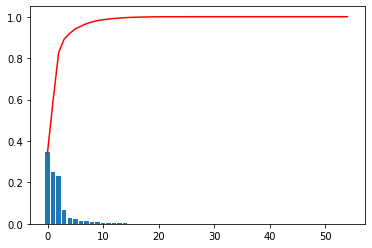

In [ ]:
from sklearn.decomposition import PCA

mypca = PCA(n_components=55) # On paramètre ici pour ne garder que 55 composantes

mypca.fit(data_tr)
mypca.singular_values_ # Valeurs de variance

mypca.explained_variance_ratio_ #  Pourcentages

mypca.components_ # 
data_sortie= mypca.fit_transform(data_tr)
mypca.noise_variance_

y = list(mypca.explained_variance_ratio_)

x = range(len(y))

ycum = np.cumsum(y)

plt.bar(x,y)

plt.plot(x,ycum,"-r")

plt.show()

## Correlations

In [ ]:
mean_med_col = [col for col in col_names if re.search('\_mean$|\_median$|label$',col)] # Colonnes moyennes et medianes
mean_med_tr = data_tr[mean_med_col]
mean_med_tr.label = mean_med_tr.label.astype(int)
mean_med_tr

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,uplink_size_mean,uplink_size_median,downlink_size_mean,downlink_size_median,both_links_size_mean,both_links_size_median,uplink_interval_mean,uplink_interval_median,downlink_interval_mean,downlink_interval_median,both_links_interval_mean,both_links_interval_median,label
0,0.013633,0.009907,113.612245,32.643157,0.013402,0.009805,136.078431,205.772966,0.006835,0.009674,125.07,148.422224,1
1,0.176876,0.328222,487.000000,392.264657,0.128085,0.254164,308.827586,214.947496,0.074292,0.198067,383.66,313.268698,0
2,0.003496,0.004608,96.857143,22.093596,0.001428,0.003718,588.986111,413.681973,0.001042,0.002882,451.19,414.950105,1
3,0.004229,0.005576,98.225806,28.208403,0.001919,0.005633,599.434783,376.788148,0.001324,0.003575,444.06,389.912910,1
4,0.003080,0.005691,96.533333,27.042410,0.001326,0.004443,649.371429,376.682782,0.000933,0.003334,483.52,404.892316,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.168442,0.449148,248.868421,22.409181,0.101848,0.321320,390.225806,295.854163,0.064008,0.256044,336.51,242.642544,0
1747,0.019276,0.023218,353.000000,250.000000,0.471743,4.252675,481.833333,437.711433,0.452873,4.166910,476.68,431.726739,0
1748,0.003944,0.005735,97.437500,27.035147,0.001856,0.004926,594.117647,376.928733,0.001262,0.003465,435.18,388.076072,1
1749,0.090587,0.253379,301.333333,65.319726,0.028760,0.116793,1625.684211,200.982401,0.021857,0.096867,1307.84,595.597565,0


In [ ]:
corr_m = mean_med_tr.corr()

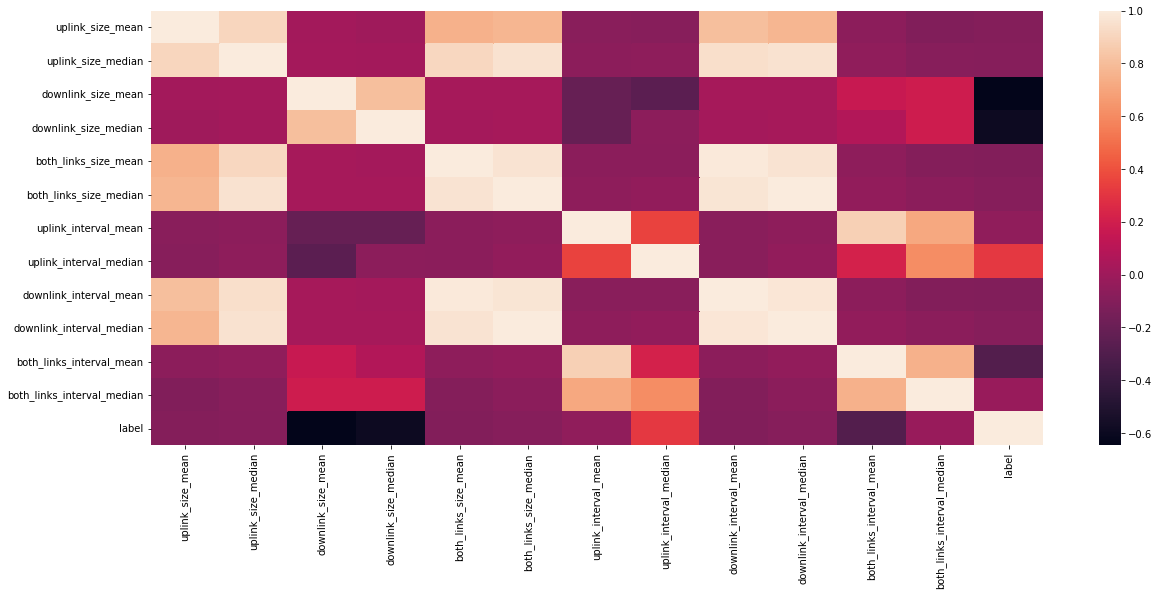

In [ ]:
# Matrice de corrélation
fig,ax = plt.subplots(figsize = (20,8))
sns.heatmap(corr_m,)

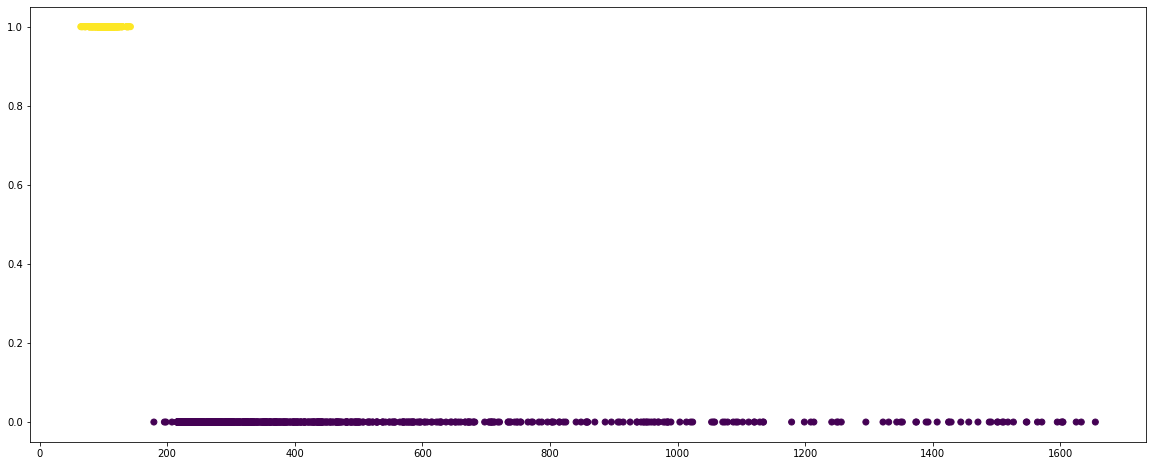

In [ ]:
fig,ax = plt.subplots(figsize = (20,8))
ax.scatter(x = mean_med_tr.downlink_size_mean,y = mean_med_tr.label,c = mean_med_tr.label)

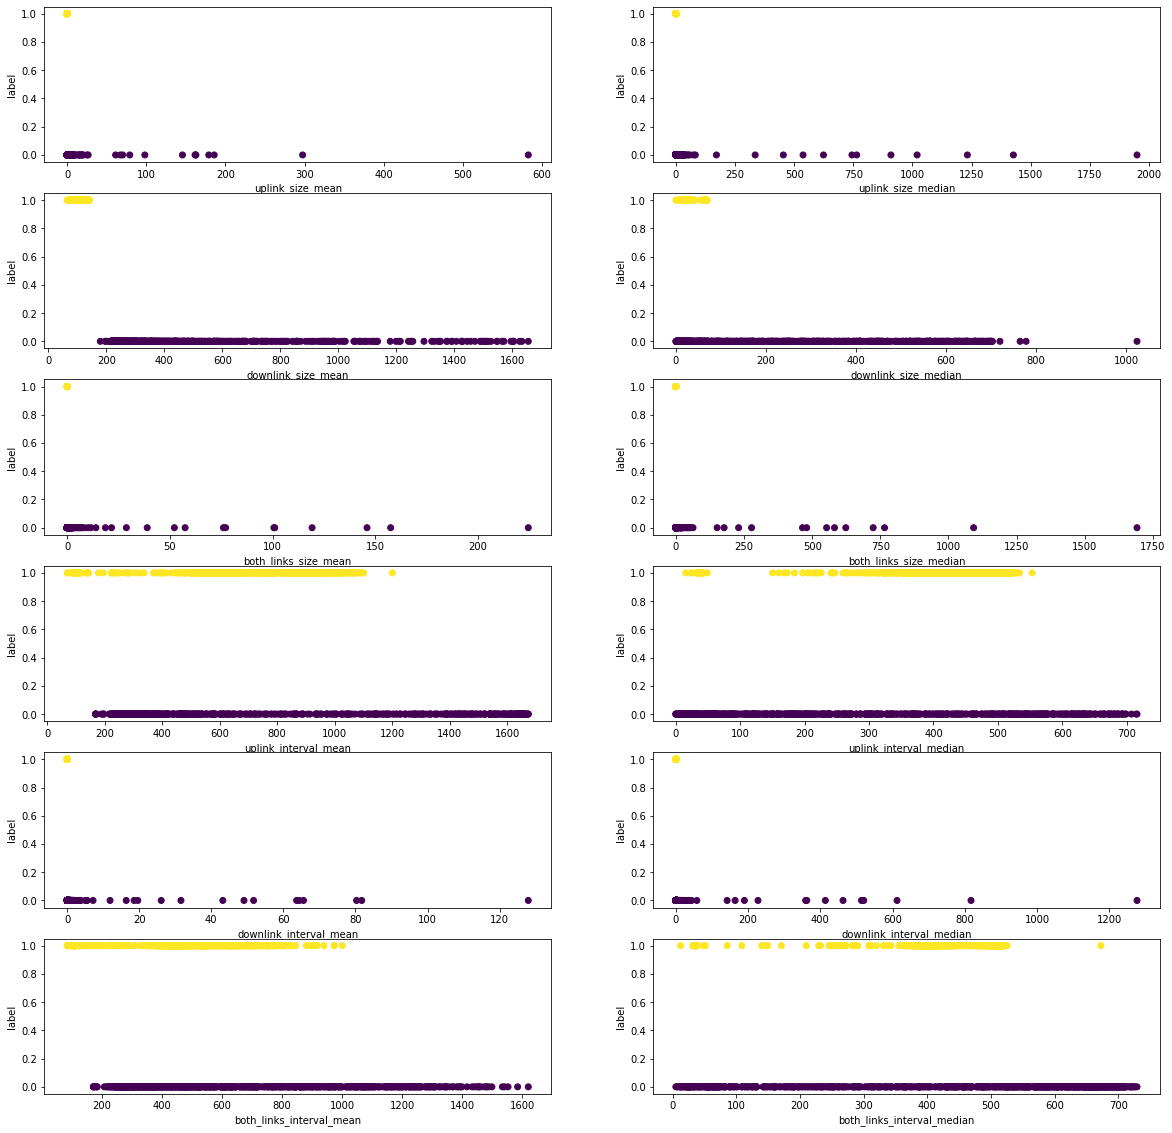

In [ ]:
nrc = int((len(mean_med_col)-1)/2)
fig,ax = plt.subplots(nrc,2,figsize = (20,20))
#ax[0][0].scatter(x = mean_med_tr.downlink_size_mean,y = mean_med_tr.label,c = mean_med_tr.label)
for i in range(nrc*2):
    col = mean_med_col[i]
    j = 0 if i%2 == 0 else 1 
    ax[i//2,j].scatter(x = mean_med_tr[col],y = mean_med_tr.label, c = mean_med_tr.label)
    ax[i//2,j].set_xlabel(col)
    ax[i//2,j].set_ylabel('label')

In [ ]:
# Proportions de labels dans le dataset tr
fig,ax = plt.subplots(figsize = (10,4))
x = (mean_med_tr.label.value_counts()/100) 
y = mean_med_tr.label.drop_duplicates()
ax.pie(x,labels = y,autopct= '%.2f')

## Machine Learning (Classification techniques)


### Scaling


In [ ]:
col_to_sc = [col for col in list(mean_med_tr.columns) if re.search('\_size_mean$|\_size_median$',col)]
scaler = StandardScaler()
mean_med_tr_sc = mean_med_tr[col_to_sc]
mean_med_tr_sc[col_to_sc] = scaler.fit_transform(mean_med_tr_sc[col_to_sc])
mean_med_tr_sc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,uplink_size_mean,uplink_size_median,downlink_size_mean,downlink_size_median,both_links_size_mean,both_links_size_median
0,-0.087521,-0.084440,-0.542954,-0.528983,-0.091042,-0.082301
1,-0.078877,-0.080486,0.805062,1.411367,-0.078719,-0.078381
2,-0.088058,-0.084506,-0.603444,-0.585904,-0.092329,-0.082398
3,-0.088019,-0.084494,-0.598502,-0.552911,-0.092276,-0.082368
4,-0.088080,-0.084493,-0.604613,-0.559202,-0.092340,-0.082387
...,...,...,...,...,...,...
1746,-0.079324,-0.078984,-0.054648,-0.584201,-0.081538,-0.077303
1747,-0.087222,-0.084275,0.321291,0.643773,-0.041793,-0.014237
1748,-0.088034,-0.084492,-0.601348,-0.559241,-0.092283,-0.082379
1749,-0.083446,-0.081416,0.134763,-0.352676,-0.089392,-0.080584


In [ ]:
mean_med_te_sc = data_te[col_to_sc]
mean_med_te_sc[col_to_sc] = scaler.fit_transform(mean_med_te_sc[col_to_sc])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

### Preparing train and test data

In [ ]:
X_tr = mean_med_tr[col_to_sc]
y_tr = mean_med_tr['label']
X_te = data_te[col_to_sc]
y_te = data_te['label']

### Using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_reg = make_pipeline(StandardScaler(),LogisticRegression())
clf_reg.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
clf_reg.score(X_tr,y_tr)

0.9994288977727013

In [ ]:
clf_reg.score(X_te,y_te)

0.9993193034205003

In [ ]:
scores = cross_val_score(clf_reg,X_tr,y_tr,cv = 5)
scores

array([1.        , 1.        , 1.        , 0.99714286, 1.        ])

In [ ]:
scores2 = cross_val_score(clf_reg,X_te,y_te,cv = 5)
scores2

array([1.        , 0.99971639, 0.99971639, 0.99943279, 0.99914894])

### Using SVC classifier

In [ ]:
from sklearn.svm import SVC
clf_svc = make_pipeline(StandardScaler(),SVC(kernel = 'linear'))
clf_svc.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [ ]:
clf_svc.score(X_tr,y_tr)

1.0

In [ ]:
clf_svc.score(X_te,y_te)

1.0

In [ ]:
y_pre_svc = clf_svc.predict(X_te)

In [ ]:
np.array_equal(y_pre_svc,y_te)

True

In [ ]:
scores = cross_val_score(clf_svc,X_tr,y_tr,cv = 5)
scores

array([1., 1., 1., 1., 1.])

In [ ]:
scores2 = cross_val_score(clf_svc,X_te,y_te,cv = 5)
scores2

array([1., 1., 1., 1., 1.])

### Using SGD Classifier

In [ ]:
# Fit the model with training data
from sklearn.linear_model import SGDClassifier
clf_sgd = make_pipeline(StandardScaler(),SGDClassifier())
clf_sgd.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# See the score for the training set
clf_sgd.score(X_tr,y_tr)

1.0

In [ ]:
# See the score for the test set
clf_sgd.score(X_te,y_te)

1.0

In [ ]:
# Cross fold validation with training data set
scores = cross_val_score(clf_sgd,X_tr,y_tr,cv = 5)
scores

array([1., 1., 1., 1., 1.])

In [ ]:
# Cross fold validation with test data set
scores2 = cross_val_score(clf_sgd,X_te,y_te,cv = 5)
scores2

array([1.        , 0.99971639, 1.        , 1.        , 1.        ])

# Dataset 2 

## Recupération des données (.mat) sous un dataframe

In [ ]:
url = 'http://mason.gmu.edu/~lzhao9/materials/data/UAV/data/pub_dataset2.mat'
r = requests.get(url, allow_redirects=True)
open('pub_dataset2.mat', 'wb').write(r.content)

5554984

In [ ]:
import h5py
data_path2 = './pub_dataset2.mat'
with h5py.File(data_path, 'r') as f:
    data_tr = pd.DataFrame(data = f['data_tr']).T
    data_te = pd.DataFrame(data = f['data_te']).T

## Renommage des colonnes

In [ ]:
url = 'https://archive.ics.uci.edu/ml/datasets/Unmanned+Aerial+Vehicle+%28UAV%29+Intrusion+Detection'
response = requests.get(url)
soup = BeautifulSoup(response.text,'html.parser')

In [ ]:
cat = soup.find_all('p',{'class':'normal'})[21] # Tous les noms des colonnes

In [ ]:
cat = cat.get_text(separator = '<br/>',strip = True).split('<br/>')[1:] # Recup le texte propre

In [ ]:
col_names = [(re.search('(?<=. )\D+',c).group()) for c in cat]
old_new_col = {i:col for i,col in enumerate(col_names)} # dictionnaire anciennes/nouvelles colonnes

In [ ]:
data_tr.rename(old_new_col,axis = 1,inplace = True)
data_te.rename(old_new_col,axis = 1,inplace = True) # Renommage des colonnes

In [ ]:
data_tr

,uplink_size_mean,uplink_size_median,uplink_size_MAD,uplink_size_STD,uplink_size_Skewness,uplink_size_Kurtosis,uplink_size_MAX,uplink_size_MIN,uplink_size_MeanSquare,downlink_size_mean,downlink_size_median,downlink_size_MAD,downlink_size_STD,downlink_size_Skewness,downlink_size_Kurtosis,downlink_size_MAX,downlink_size_MIN,downlink_size_MeanSquare,both_links_size_mean,both_links_size_median,both_links_size_MAD,both_links_size_STD,both_links_size_Skewness,both_links_size_Kurtosis,both_links_size_MAX,both_links_size_MIN,both_links_size_MeanSquare,uplink_interval_mean,uplink_interval_median,uplink_interval_MAD,uplink_interval_STD,uplink_interval_Skewness,uplink_interval_Kurtosis,uplink_interval_MAX,uplink_interval_MIN,uplink_interval_MeanSquare,downlink_interval_mean,downlink_interval_median,downlink_interval_MAD,downlink_interval_STD,downlink_interval_Skewness,downlink_interval_Kurtosis,downlink_interval_MAX,downlink_interval_MIN,downlink_interval_MeanSquare,both_links_interval_mean,both_links_interval_median,both_links_interval_MAD,both_links_interval_STD,both_links_interval_Skewness,both_links_interval_Kurtosis,both_links_interval_MAX,both_links_interval_MIN,both_links_interval_MeanSquare,label
0,0.013633,0.009907,0.012473,0.013195,0.206939,-1.518004,0.029022,0.000002,0.016793,113.612245,32.643157,138.0,17.7912,-0.524785,-1.621986,153.0,70.0,118.116770,0.013402,0.009805,0.012023,0.012642,0.254736,-1.480650,0.029021,0.000408,0.016549,136.078431,205.772966,70.0,0.0000,4.398569,18.352606,1130.0,70.0,245.009404,0.006835,0.009674,0.000241,0.000351,1.164627,-0.178463,0.028997,0.000002,0.011805,125.07,148.422224,126.0,83.0256,6.183629,39.041176,1130.0,70.0,193.523564,1.0
1,0.176876,0.328222,0.050990,0.072377,2.746796,7.799352,1.629773,0.000309,0.369391,487.000000,392.264657,395.5,255.7485,1.692933,1.546272,1476.0,222.0,622.396138,0.128085,0.254164,0.029409,0.043299,3.309583,12.659707,1.482584,0.000143,0.282651,308.827586,214.947496,264.0,63.7518,3.713849,12.835863,1293.0,216.0,375.207023,0.074292,0.198067,0.001850,0.002549,4.688625,25.950990,1.478154,0.000117,0.210612,383.66,313.268698,307.0,126.0210,2.542834,5.425483,1476.0,216.0,494.318622,0.0
2,0.003496,0.004608,0.001605,0.001622,1.884811,2.649103,0.018668,0.000177,0.005718,96.857143,22.093596,88.0,0.0000,1.932871,1.804209,150.0,88.0,99.257242,0.001428,0.003718,0.000158,0.000228,3.658123,13.575117,0.020585,0.000001,0.003959,588.986111,413.681973,741.5,457.3821,-0.272712,-1.735861,1108.0,76.0,718.095098,0.001042,0.002882,0.000025,0.000035,4.084852,17.829972,0.018668,0.000001,0.003051,451.19,414.950105,150.0,109.7124,0.358598,-1.731709,1108.0,76.0,611.583330,1.0
3,0.004229,0.005576,0.000986,0.001195,1.088090,-0.287253,0.018410,0.000009,0.006926,98.225806,28.208403,88.0,0.0000,2.800722,8.100519,218.0,76.0,102.070343,0.001919,0.005633,0.000105,0.000153,3.661035,13.732723,0.032340,0.000001,0.005912,599.434783,376.788148,770.0,240.1812,-0.435652,-1.484070,1094.0,76.0,706.564817,0.001324,0.003575,0.000067,0.000096,3.100149,8.892516,0.018410,0.000001,0.003795,444.06,389.912910,147.0,105.2646,0.311359,-1.699683,1094.0,76.0,589.661801,1.0
4,0.003080,0.005691,0.000934,0.000975,2.881301,8.274496,0.026786,0.000011,0.006387,96.533333,27.042410,88.0,0.0000,3.245917,10.956115,218.0,76.0,100.127918,0.001326,0.004443,0.000034,0.000040,4.790659,24.285991,0.029226,0.000007,0.004606,649.371429,376.682782,794.0,235.7334,-0.564116,-1.208588,1218.0,76.0,749.363844,0.000933,0.003334,0.000029,0.000031,5.731184,36.394334,0.026335,0.000007,0.003446,483.52,404.892316,417.0,505.5666,0.198671,-1.704260,1218.0,76.0,629.356815,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.168442,0.449148,0.024904,0.036848,3.425184,11.482435,2.269895,0.000102,0.474128,248.868421,22.409181,228.0,0.0000,0.127789,-2.008487,276.0,228.0,249.848849,0.1

Ici aussi la majorité de l'information est transporté par une dizaine de variables. 

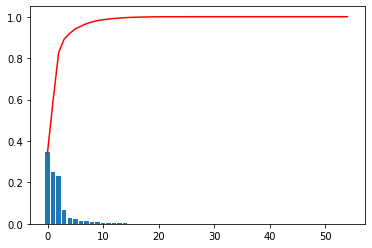

In [ ]:
from sklearn.decomposition import PCA

mypca = PCA(n_components=55) # On paramètre ici pour ne garder que 55 composantes

mypca.fit(data_tr)
mypca.singular_values_ # Valeurs de variance

mypca.explained_variance_ratio_ #  Pourcentages

mypca.components_ # 
data_sortie= mypca.fit_transform(data_tr)
mypca.noise_variance_

y = list(mypca.explained_variance_ratio_)

x = range(len(y))

ycum = np.cumsum(y)

plt.bar(x,y)

plt.plot(x,ycum,"-r")

plt.show()

## Visualisation

## Correlations

In [ ]:
# import re
# r1 = re.compile("\.pdf$")  # regular expression corrected
# if re.search("\.pdf$","spam.pdf"):  # re.match() replaced with re.search()
#     print("yes")
# else:
#     print("no")

In [ ]:
mean_med_col = [col for col in col_names if re.search('\_mean$|\_median$|label$',col)] # Colonnes moyennes et medianes
mean_med_tr = data_tr[mean_med_col]
mean_med_tr.label = mean_med_tr.label.astype(int)
mean_med_tr

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,uplink_size_mean,uplink_size_median,downlink_size_mean,downlink_size_median,both_links_size_mean,both_links_size_median,uplink_interval_mean,uplink_interval_median,downlink_interval_mean,downlink_interval_median,both_links_interval_mean,both_links_interval_median,label
0,0.013633,0.009907,113.612245,32.643157,0.013402,0.009805,136.078431,205.772966,0.006835,0.009674,125.07,148.422224,1
1,0.176876,0.328222,487.000000,392.264657,0.128085,0.254164,308.827586,214.947496,0.074292,0.198067,383.66,313.268698,0
2,0.003496,0.004608,96.857143,22.093596,0.001428,0.003718,588.986111,413.681973,0.001042,0.002882,451.19,414.950105,1
3,0.004229,0.005576,98.225806,28.208403,0.001919,0.005633,599.434783,376.788148,0.001324,0.003575,444.06,389.912910,1
4,0.003080,0.005691,96.533333,27.042410,0.001326,0.004443,649.371429,376.682782,0.000933,0.003334,483.52,404.892316,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.168442,0.449148,248.868421,22.409181,0.101848,0.321320,390.225806,295.854163,0.064008,0.256044,336.51,242.642544,0
1747,0.019276,0.023218,353.000000,250.000000,0.471743,4.252675,481.833333,437.711433,0.452873,4.166910,476.68,431.726739,0
1748,0.003944,0.005735,97.437500,27.035147,0.001856,0.004926,594.117647,376.928733,0.001262,0.003465,435.18,388.076072,1
1749,0.090587,0.253379,301.333333,65.319726,0.028760,0.116793,1625.684211,200.982401,0.021857,0.096867,1307.84,595.597565,0


In [ ]:
corr_m = mean_med_tr.corr()

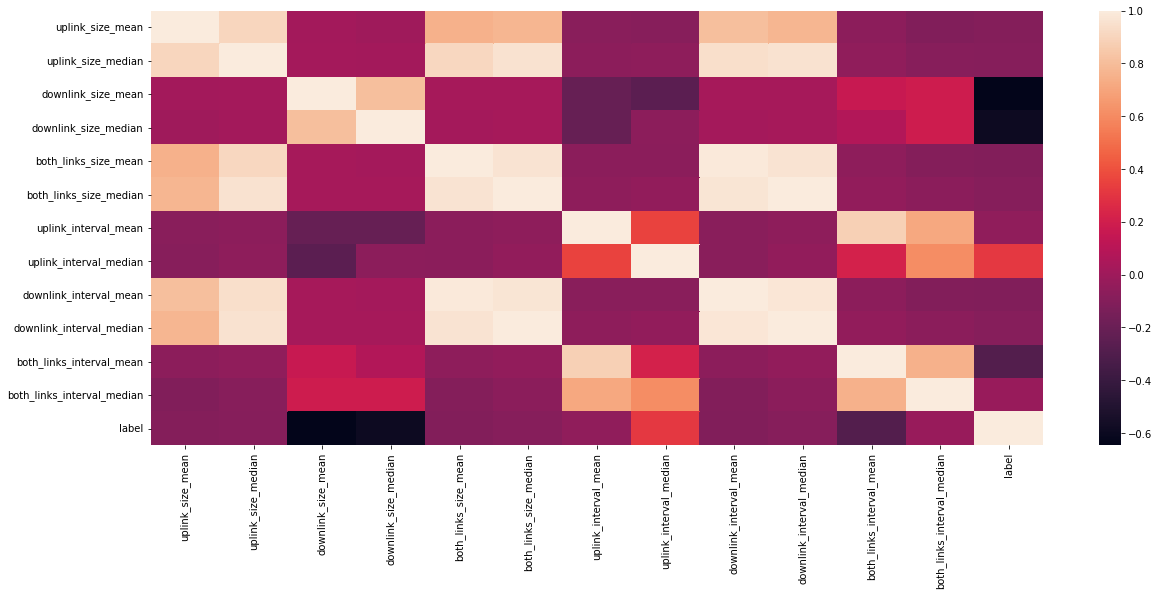

In [ ]:
# Matrice de corrélation
fig,ax = plt.subplots(figsize = (20,8))
sns.heatmap(corr_m,)

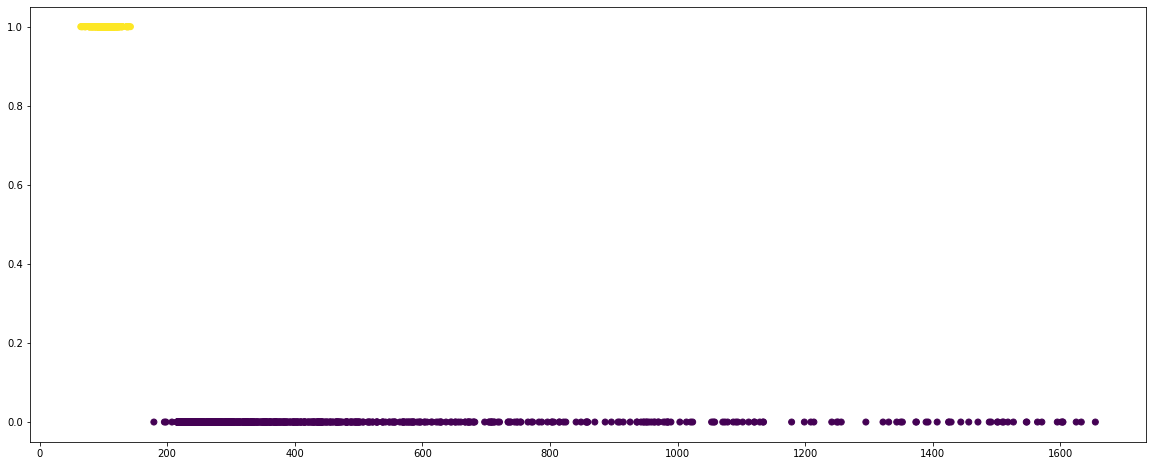

In [ ]:
fig,ax = plt.subplots(figsize = (20,8))
ax.scatter(x = mean_med_tr.downlink_size_mean,y = mean_med_tr.label,c = mean_med_tr.label)

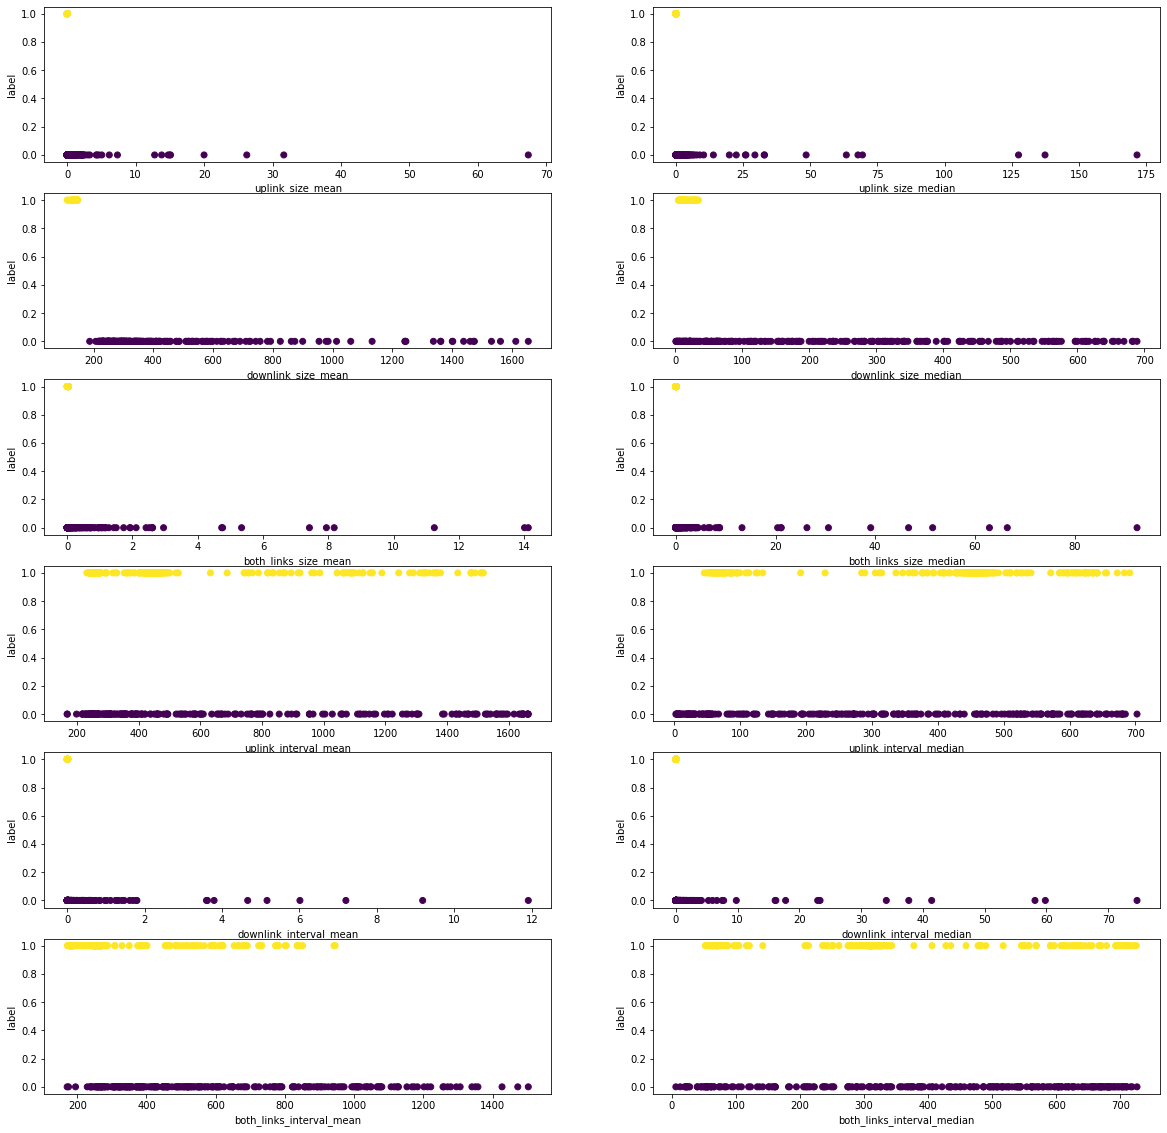

In [ ]:
nrc = int((len(mean_med_col)-1)/2)
fig,ax = plt.subplots(nrc,2,figsize = (20,20))
#ax[0][0].scatter(x = mean_med_tr.downlink_size_mean,y = mean_med_tr.label,c = mean_med_tr.label)
  
for i in range(nrc*2):
    col = mean_med_col[i]
    j = 0 if i%2 == 0 else 1    
    ax[i//2,j].scatter(x = mean_med_tr[col],y = mean_med_tr.label, c = mean_med_tr.label)
    ax[i//2,j].set_xlabel(col)
    ax[i//2,j].set_ylabel('label')

([<matplotlib.patches.Wedge at 0x7f80f81d3950>,
 [Text(-0.16027466327212386, 1.0882610129527786, '1'),
  Text(0.1602745613817736, -1.0882610279587706, '0')],
 [Text(-0.08742254360297665, 0.5935969161560609, '54.65'),
  Text(0.08742248802642195, -0.5935969243411475, '45.35')])

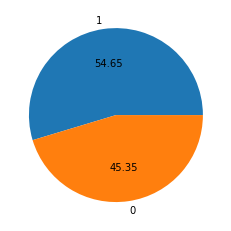

In [ ]:
# Proportions de labels dans le dataset tr
fig,ax = plt.subplots(figsize = (10,4))
x = (mean_med_tr.label.value_counts()/100) 
y = mean_med_tr.label.drop_duplicates()
ax.pie(x,labels = y,autopct= '%.2f')

## Machine Learning (Classification techniques)


### Scaling


In [ ]:
col_to_sc = [col for col in list(mean_med_tr.columns) if re.search('\_size_mean$|\_size_median$',col)]
scaler = StandardScaler()
mean_med_tr_sc = mean_med_tr[col_to_sc]
mean_med_tr_sc[col_to_sc] = scaler.fit_transform(mean_med_tr_sc[col_to_sc])
mean_med_tr_sc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,uplink_size_mean,uplink_size_median,downlink_size_mean,downlink_size_median,both_links_size_mean,both_links_size_median
0,-0.087521,-0.084440,-0.542954,-0.528983,-0.091042,-0.082301
1,-0.078877,-0.080486,0.805062,1.411367,-0.078719,-0.078381
2,-0.088058,-0.084506,-0.603444,-0.585904,-0.092329,-0.082398
3,-0.088019,-0.084494,-0.598502,-0.552911,-0.092276,-0.082368
4,-0.088080,-0.084493,-0.604613,-0.559202,-0.092340,-0.082387
...,...,...,...,...,...,...
1746,-0.079324,-0.078984,-0.054648,-0.584201,-0.081538,-0.077303
1747,-0.087222,-0.084275,0.321291,0.643773,-0.041793,-0.014237
1748,-0.088034,-0.084492,-0.601348,-0.559241,-0.092283,-0.082379
1749,-0.083446,-0.081416,0.134763,-0.352676,-0.089392,-0.080584


In [ ]:
mean_med_te_sc = data_te[col_to_sc]
mean_med_te_sc[col_to_sc] = scaler.fit_transform(mean_med_te_sc[col_to_sc])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

### Preparing train and test data

In [ ]:
X_tr = mean_med_tr_sc
y_tr = mean_med_tr['label']
X_te = mean_med_te_sc
y_te = data_te['label']

### Using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_reg = make_pipeline(StandardScaler(),LogisticRegression())
clf_reg.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
clf_reg.score(X_tr,y_tr)

0.9994288977727013

In [ ]:
clf_reg.score(X_te,y_te)

0.9994327528504169

In [ ]:
scores = cross_val_score(clf_reg,X_tr,y_tr,cv = 5)
scores

array([1.        , 1.        , 1.        , 0.99714286, 1.        ])

In [ ]:
scores2 = cross_val_score(clf_reg,X_te,y_te,cv = 5)
scores2

array([1.        , 0.99971639, 0.99971639, 0.99943279, 0.99914894])

### Using SVC classifier

In [ ]:
from sklearn.svm import SVC
clf_svc = make_pipeline(StandardScaler(),SVC(kernel = 'linear'))
clf_svc.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [ ]:
clf_svc.score(X_tr,y_tr)

1.0

In [ ]:
clf_svc.score(X_te,y_te)

1.0

In [ ]:
y_pre_svc = clf_svc.predict(X_te)

In [ ]:
np.array_equal(y_pre_svc,y_te)

True

In [ ]:
scores = cross_val_score(clf_svc,X_tr,y_tr,cv = 5)
scores

array([1., 1., 1., 1., 1.])

In [ ]:
scores2 = cross_val_score(clf_svc,X_te,y_te,cv = 5)
scores2

array([1., 1., 1., 1., 1.])

### Using SGD Classifier

In [ ]:
# Fit the model with training data
from sklearn.linear_model import SGDClassifier
clf_sgd = make_pipeline(StandardScaler(),SGDClassifier())
clf_sgd.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# See the score for the training set
clf_sgd.score(X_tr,y_tr)

0.9994288977727013

In [ ]:
# See the score for the test set
clf_sgd.score(X_te,y_te)

0.9992058539905837

In [ ]:
# Cross fold validation with training data set
scores = cross_val_score(clf_sgd,X_tr,y_tr,cv = 5)
scores

array([1.        , 1.        , 1.        , 0.99714286, 1.        ])

In [ ]:
# Cross fold validation with test data set
scores2 = cross_val_score(clf_sgd,X_te,y_te,cv = 5)
scores2

array([1.        , 0.99971639, 1.        , 1.        , 1.        ])

# Dataset 3

## Recupération des données (.mat) sous un dataframe

In [ ]:
url = 'http://mason.gmu.edu/~lzhao9/materials/data/UAV/data/pub_dataset3.mat'
r = requests.get(url, allow_redirects=True)
open('pub_dataset3.mat', 'wb').write(r.content)

1783318

In [ ]:
import h5py
data_path = './pub_dataset3.mat'
with h5py.File(data_path, 'r') as f:
    data_tr = pd.DataFrame(data = f['data_tr']).T
    data_te = pd.DataFrame(data = f['data_te']).T

## Renommage des colonnes

In [ ]:
from bs4 import BeautifulSoup
url = 'https://archive.ics.uci.edu/ml/datasets/Unmanned+Aerial+Vehicle+%28UAV%29+Intrusion+Detection'
response = requests.get(url)
soup = BeautifulSoup(response.text,'html.parser')

In [ ]:
cat = soup.find_all('p',{'class':'normal'})[21] # Tous les noms des colonnes

In [ ]:
cat = cat.get_text(separator = '<br/>',strip = True).split('<br/>')[1:] # Recup le texte propre

In [ ]:
col_names = [(re.search('(?<=. )\D+',c).group()) for c in cat]
old_new_col = {i:col for i,col in enumerate(col_names)} # dictionnaire anciennes/nouvelles colonnes

In [ ]:
data_tr.rename(old_new_col,axis = 1,inplace = True)
data_te.rename(old_new_col,axis = 1,inplace = True) # Renommage des colonnes

In [ ]:
data_tr

,uplink_size_mean,uplink_size_median,uplink_size_MAD,uplink_size_STD,uplink_size_Skewness,uplink_size_Kurtosis,uplink_size_MAX,uplink_size_MIN,uplink_size_MeanSquare,downlink_size_mean,downlink_size_median,downlink_size_MAD,downlink_size_STD,downlink_size_Skewness,downlink_size_Kurtosis,downlink_size_MAX,downlink_size_MIN,downlink_size_MeanSquare,both_links_size_mean,both_links_size_median,both_links_size_MAD,both_links_size_STD,both_links_size_Skewness,both_links_size_Kurtosis,both_links_size_MAX,both_links_size_MIN,both_links_size_MeanSquare,uplink_interval_mean,uplink_interval_median,uplink_interval_MAD,uplink_interval_STD,uplink_interval_Skewness,uplink_interval_Kurtosis,uplink_interval_MAX,uplink_interval_MIN,uplink_interval_MeanSquare,downlink_interval_mean,downlink_interval_median,downlink_interval_MAD,downlink_interval_STD,downlink_interval_Skewness,downlink_interval_Kurtosis,downlink_interval_MAX,downlink_interval_MIN,downlink_interval_MeanSquare,both_links_interval_mean,both_links_interval_median,both_links_interval_MAD,both_links_interval_STD,both_links_interval_Skewness,both_links_interval_Kurtosis,both_links_interval_MAX,both_links_interval_MIN,both_links_interval_MeanSquare,label
0,0.013633,0.009907,0.012473,0.013195,0.206939,-1.518004,0.029022,0.000002,0.016793,113.612245,32.643157,138.0,17.7912,-0.524785,-1.621986,153.0,70.0,118.116770,0.013402,0.009805,0.012023,0.012642,0.254736,-1.480650,0.029021,0.000408,0.016549,136.078431,205.772966,70.0,0.0000,4.398569,18.352606,1130.0,70.0,245.009404,0.006835,0.009674,0.000241,0.000351,1.164627,-0.178463,0.028997,0.000002,0.011805,125.07,148.422224,126.0,83.0256,6.183629,39.041176,1130.0,70.0,193.523564,1.0
1,0.176876,0.328222,0.050990,0.072377,2.746796,7.799352,1.629773,0.000309,0.369391,487.000000,392.264657,395.5,255.7485,1.692933,1.546272,1476.0,222.0,622.396138,0.128085,0.254164,0.029409,0.043299,3.309583,12.659707,1.482584,0.000143,0.282651,308.827586,214.947496,264.0,63.7518,3.713849,12.835863,1293.0,216.0,375.207023,0.074292,0.198067,0.001850,0.002549,4.688625,25.950990,1.478154,0.000117,0.210612,383.66,313.268698,307.0,126.0210,2.542834,5.425483,1476.0,216.0,494.318622,0.0
2,0.003496,0.004608,0.001605,0.001622,1.884811,2.649103,0.018668,0.000177,0.005718,96.857143,22.093596,88.0,0.0000,1.932871,1.804209,150.0,88.0,99.257242,0.001428,0.003718,0.000158,0.000228,3.658123,13.575117,0.020585,0.000001,0.003959,588.986111,413.681973,741.5,457.3821,-0.272712,-1.735861,1108.0,76.0,718.095098,0.001042,0.002882,0.000025,0.000035,4.084852,17.829972,0.018668,0.000001,0.003051,451.19,414.950105,150.0,109.7124,0.358598,-1.731709,1108.0,76.0,611.583330,1.0
3,0.004229,0.005576,0.000986,0.001195,1.088090,-0.287253,0.018410,0.000009,0.006926,98.225806,28.208403,88.0,0.0000,2.800722,8.100519,218.0,76.0,102.070343,0.001919,0.005633,0.000105,0.000153,3.661035,13.732723,0.032340,0.000001,0.005912,599.434783,376.788148,770.0,240.1812,-0.435652,-1.484070,1094.0,76.0,706.564817,0.001324,0.003575,0.000067,0.000096,3.100149,8.892516,0.018410,0.000001,0.003795,444.06,389.912910,147.0,105.2646,0.311359,-1.699683,1094.0,76.0,589.661801,1.0
4,0.003080,0.005691,0.000934,0.000975,2.881301,8.274496,0.026786,0.000011,0.006387,96.533333,27.042410,88.0,0.0000,3.245917,10.956115,218.0,76.0,100.127918,0.001326,0.004443,0.000034,0.000040,4.790659,24.285991,0.029226,0.000007,0.004606,649.371429,376.682782,794.0,235.7334,-0.564116,-1.208588,1218.0,76.0,749.363844,0.000933,0.003334,0.000029,0.000031,5.731184,36.394334,0.026335,0.000007,0.003446,483.52,404.892316,417.0,505.5666,0.198671,-1.704260,1218.0,76.0,629.356815,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.168442,0.449148,0.024904,0.036848,3.425184,11.482435,2.269895,0.000102,0.474128,248.868421,22.409181,228.0,0.0000,0.127789,-2.008487,276.0,228.0,249.848849,0.1

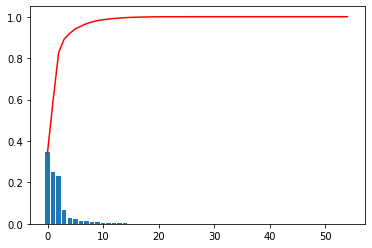

In [ ]:
from sklearn.decomposition import PCA

mypca = PCA(n_components=55) # On paramètre ici pour ne garder que 55 composantes

mypca.fit(data_tr)
mypca.singular_values_ # Valeurs de variance

mypca.explained_variance_ratio_ #  Pourcentages

mypca.components_ # 
data_sortie= mypca.fit_transform(data_tr)
mypca.noise_variance_

y = list(mypca.explained_variance_ratio_)

x = range(len(y))

ycum = np.cumsum(y)

plt.bar(x,y)

plt.plot(x,ycum,"-r")

plt.show()

## Correlations

In [ ]:
mean_med_col = [col for col in col_names if re.search('\_mean$|\_median$|label$',col)] # Colonnes moyennes et medianes
mean_med_tr = data_tr[mean_med_col]
mean_med_tr.label = mean_med_tr.label.astype(int)
mean_med_tr

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,uplink_size_mean,uplink_size_median,downlink_size_mean,downlink_size_median,both_links_size_mean,both_links_size_median,uplink_interval_mean,uplink_interval_median,downlink_interval_mean,downlink_interval_median,both_links_interval_mean,both_links_interval_median,label
0,0.016384,0.017049,143.761905,10.153204,0.027829,0.029467,439.297297,450.704564,0.010322,0.015365,253.11,307.402934,1
1,0.284070,0.828884,252.285714,95.664724,0.153040,0.568284,1430.307692,514.807000,0.099479,0.459503,1018.00,702.404442,0
2,0.016612,0.015893,143.322581,10.016010,0.026316,0.029797,452.447368,462.604302,0.010308,0.014524,260.79,320.598723,1
3,0.016395,0.016500,143.590164,9.851188,0.025708,0.029713,432.128205,448.110547,0.010026,0.014839,256.12,311.674470,1
4,0.017476,0.016967,142.901639,9.833116,0.027352,0.029847,427.333333,416.127785,0.010674,0.015426,253.83,293.199248,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.193349,0.590532,289.000000,4.000000,0.051793,0.286426,1643.619048,142.835477,0.043509,0.252197,1426.88,515.966354,0
496,0.014869,0.033200,354.153846,402.755413,0.008444,0.027909,1524.147541,411.071439,0.006361,0.021258,1067.85,702.582658,0
497,0.005127,0.008620,310.545455,160.087884,0.002122,0.005002,1385.492537,531.691451,0.001692,0.004543,1030.76,674.397421,0
498,2.986887,10.339577,245.487179,46.505728,2.417339,8.419928,286.803279,146.923202,1.474586,6.645075,270.69,119.678922,0


In [ ]:
mean_med_tr.columns

Index(['uplink_size_mean', 'uplink_size_median', 'downlink_size_mean',
       'downlink_size_median', 'both_links_size_mean',
       'both_links_size_median', 'uplink_interval_mean',
       'uplink_interval_median', 'downlink_interval_mean',
       'downlink_interval_median', 'both_links_interval_mean',
       'both_links_interval_median', 'label'],
      dtype='object')

In [ ]:
corr_m = mean_med_tr.corr()

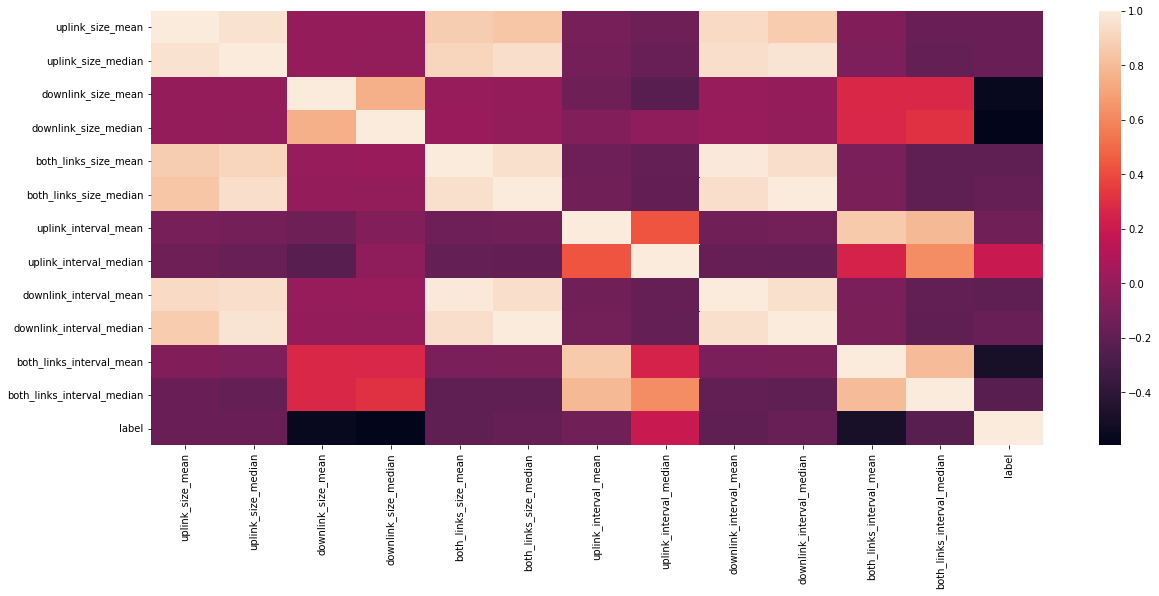

In [ ]:
# Matrice de corrélation
fig,ax = plt.subplots(figsize = (20,8))
sns.heatmap(corr_m,)

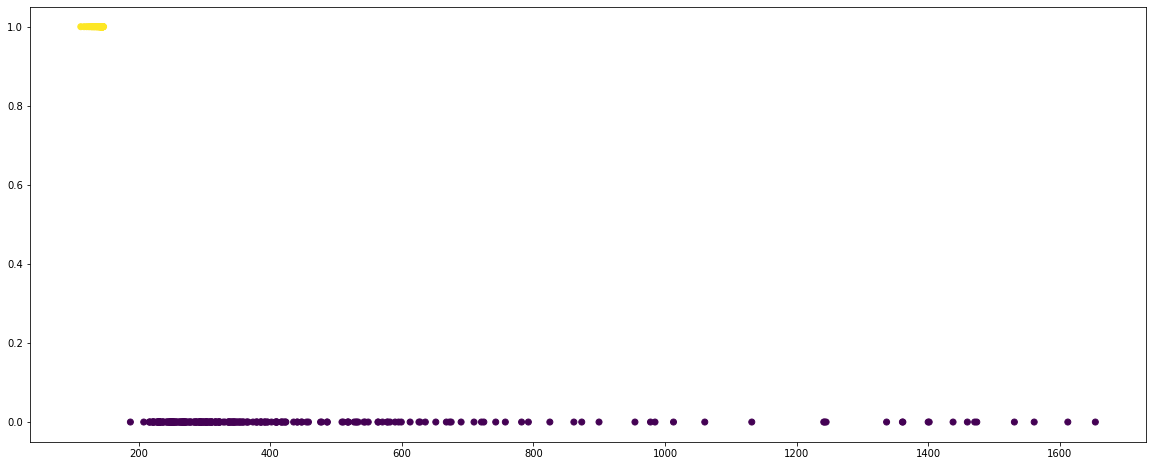

In [ ]:
fig,ax = plt.subplots(figsize = (20,8))
ax.scatter(x = mean_med_tr.downlink_size_mean,y = mean_med_tr.label,c = mean_med_tr.label)

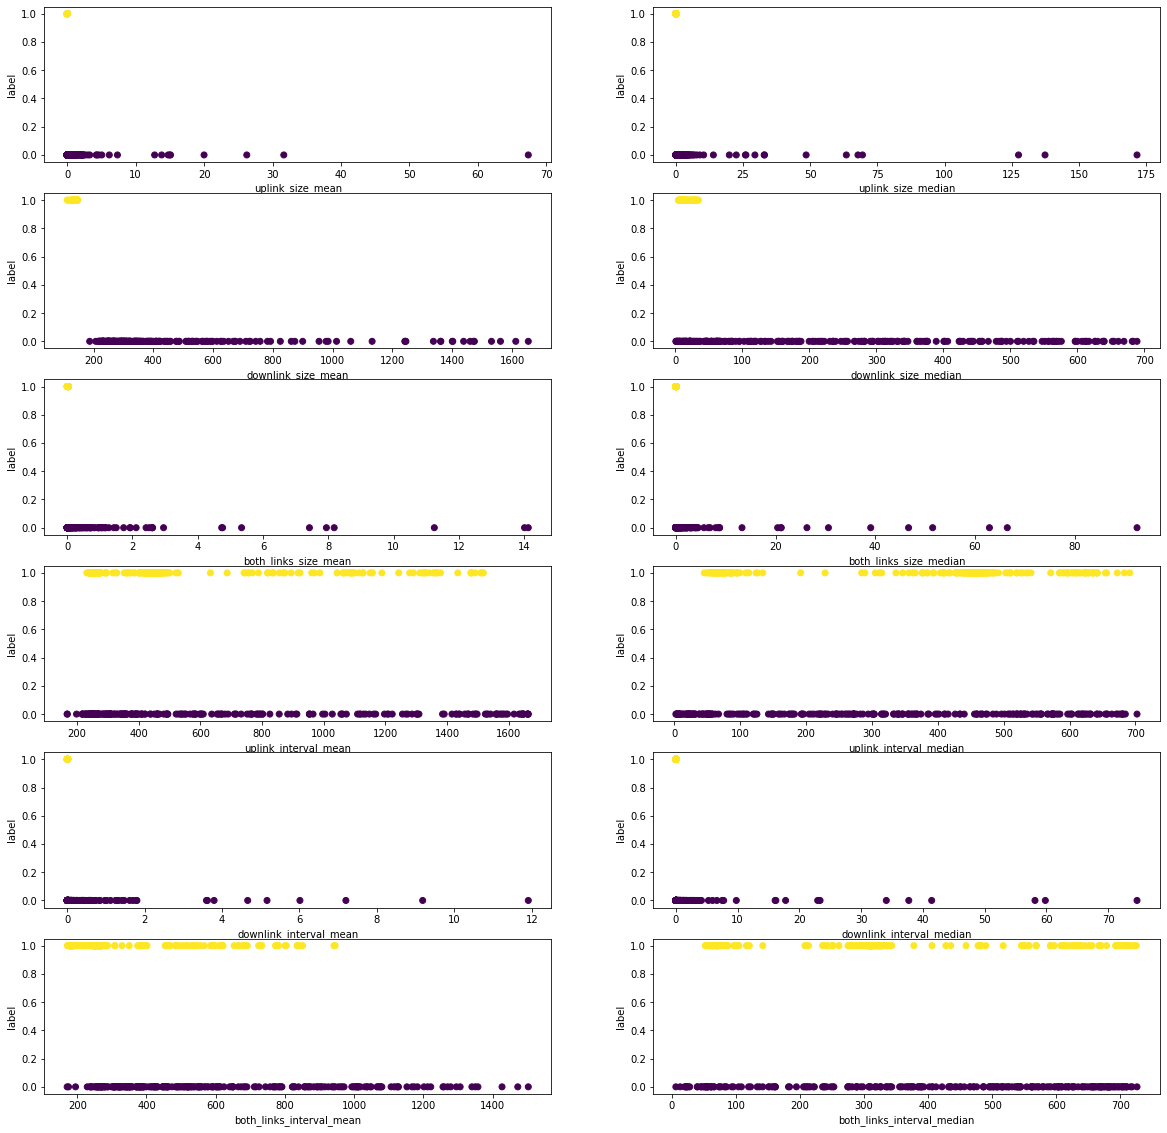

In [ ]:
nrc = int((len(mean_med_col)-1)/2)
fig,ax = plt.subplots(nrc,2,figsize = (20,20))
#ax[0][0].scatter(x = mean_med_tr.downlink_size_mean,y = mean_med_tr.label,c = mean_med_tr.label)
for i in range(nrc*2):
    col = mean_med_col[i]
    j = 0 if i%2 == 0 else 1  
    ax[i//2,j].scatter(x = mean_med_tr[col],y = mean_med_tr.label, c = mean_med_tr.label)
    ax[i//2,j].set_xlabel(col)
    ax[i//2,j].set_ylabel('label')

([<matplotlib.patches.Wedge at 0x7f80f6ffddd0>,
 [Text(-0.10351925128402176, 1.0951181509835346, '1'),
  Text(0.10351925128402162, -1.0951181509835346, '0')],
 [Text(-0.05646504615492095, 0.597337173263746, '53.00'),
  Text(0.05646504615492087, -0.597337173263746, '47.00')])

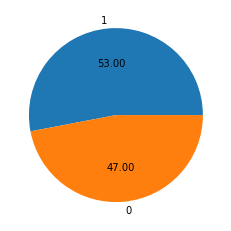

In [ ]:
# Proportions de labels dans le dataset tr
fig,ax = plt.subplots(figsize = (10,4))
x = (mean_med_tr.label.value_counts()/100) 
y = mean_med_tr.label.drop_duplicates()
ax.pie(x,labels = y,autopct= '%.2f')

## Machine Learning (Classification techniques)


### Scaling


In [ ]:
col_to_sc = [col for col in list(mean_med_tr.columns) if re.search('\_size_mean$|\_size_median$',col)]
scaler = StandardScaler()
mean_med_tr_sc = mean_med_tr[col_to_sc]
mean_med_tr_sc[col_to_sc] = scaler.fit_transform(mean_med_tr_sc[col_to_sc])
mean_med_tr_sc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,uplink_size_mean,uplink_size_median,downlink_size_mean,downlink_size_median,both_links_size_mean,both_links_size_median
0,-0.172122,-0.172241,-0.589246,-0.641578,-0.212724,-0.185513
1,-0.104005,-0.109686,-0.181733,-0.177741,-0.115072,-0.111011
2,-0.172064,-0.172330,-0.590896,-0.642323,-0.213904,-0.185467
3,-0.172120,-0.172283,-0.589891,-0.643217,-0.214378,-0.185479
4,-0.171844,-0.172247,-0.592477,-0.643315,-0.213096,-0.185460
...,...,...,...,...,...,...
495,-0.127091,-0.128052,-0.043869,-0.674955,-0.194035,-0.149983
496,-0.172508,-0.170996,0.200788,1.488002,-0.227842,-0.185728
497,-0.174987,-0.172890,0.037036,0.171708,-0.232773,-0.188895
498,0.583768,0.623144,-0.207262,-0.444393,1.650855,0.974622


In [ ]:
mean_med_te_sc = data_te[col_to_sc]
mean_med_te_sc[col_to_sc] = scaler.fit_transform(mean_med_te_sc[col_to_sc])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

### Preparing train and test data

In [ ]:
X_tr = mean_med_tr_sc
y_tr = mean_med_tr['label']
X_te = mean_med_te_sc
y_te = data_te['label']

### Using logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_reg = make_pipeline(StandardScaler(),LogisticRegression())
clf_reg.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
clf_reg.score(X_tr,y_tr)

0.99

In [ ]:
clf_reg.score(X_te,y_te)

0.9992

In [ ]:
scores = cross_val_score(clf_reg,X_tr,y_tr,cv = 5)
scores

array([0.98, 0.98, 0.99, 0.98, 1.  ])

In [ ]:
scores2 = cross_val_score(clf_reg,X_te,y_te,cv = 5)
scores2

array([0.998, 1.   , 0.999, 0.998, 0.999])

### Using SVC classifier

In [ ]:
from sklearn.svm import SVC
clf_svc = make_pipeline(StandardScaler(),SVC(kernel = 'linear'))
clf_svc.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [ ]:
clf_svc.score(X_tr,y_tr)

0.998

In [ ]:
clf_svc.score(X_te,y_te)

0.9994

In [ ]:
y_pre_svc = clf_svc.predict(X_te)

In [ ]:
np.array_equal(y_pre_svc,y_te)

False

In [ ]:
scores = cross_val_score(clf_svc,X_tr,y_tr,cv = 5)
scores

array([1.  , 1.  , 1.  , 0.99, 1.  ])

In [ ]:
scores2 = cross_val_score(clf_svc,X_te,y_te,cv = 5)
scores2

array([0.999, 1.   , 1.   , 0.999, 0.999])

### Using SGD Classifier

In [ ]:
# Fit the model with training data
from sklearn.linear_model import SGDClassifier
clf_sgd = make_pipeline(StandardScaler(),SGDClassifier())
clf_sgd.fit(X_tr,y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
# See the score for the training set
clf_sgd.score(X_tr,y_tr)

0.998

In [ ]:
# See the score for the test set
clf_sgd.score(X_te,y_te)

0.9994

In [ ]:
# Cross fold validation with training data set
scores = cross_val_score(clf_sgd,X_tr,y_tr,cv = 5)
scores

array([1., 1., 1., 1., 1.])

In [ ]:
# Cross fold validation with test data set
scores2 = cross_val_score(clf_sgd,X_te,y_te,cv = 5)
scores2

array([0.999, 1.   , 1.   , 0.999, 0.999])

# Combinaison des trois datasets

In [ ]:
full_data_tr = pd.DataFrame()
full_data_te = pd.DataFrame()
for i in range(1,4):
  data_path = './pub_dataset{}.mat'.format(i)
  with h5py.File(data_path, 'r') as f:
        full_data_tr = full_data_tr.append(pd.DataFrame(data=f['data_tr']).T,ignore_index = True)
        full_data_te = full_data_te.append(pd.DataFrame(data=f['data_te']).T,ignore_index = True)

In [ ]:
def rename_columns(ds):
    url = 'https://archive.ics.uci.edu/ml/datasets/Unmanned+Aerial+Vehicle+%28UAV%29+Intrusion+Detection'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    cat = soup.find_all('p', {'class': 'normal'})[21]
    cat = cat.get_text(separator='<br/>', strip=True).split('<br/>')[1:]
    col_names = [(re.search('(?<=. )\D+', c).group()) for c in cat]
    old_new_col = {i: col for i, col in enumerate(col_names)}
    ds.rename(old_new_col, axis=1, inplace=True)

    return ds

In [ ]:
def filter_scale(ds):
    fil_col = [col for col in list(ds.columns) if re.search(
        '\_size_mean$|\_size_median$', col)]
    ds_sc = ds[fil_col]
    return ds_sc

In [ ]:
full_data_tr = rename_columns(full_data_tr)
full_data_te = rename_columns(full_data_te)
X_tr = filter_scale(full_data_tr)
y_tr = full_data_tr['label']
X_te = filter_scale(full_data_te)
y_te = full_data_te['label']

In [ ]:
clf_svc = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf_svc.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [ ]:
clf_svc.score(X_tr,y_tr)

0.999738219895288

In [ ]:
clf_svc.score(X_te,y_te)

0.9995563211191147

In [ ]:
scores = cross_val_score(clf_svc,X_tr,y_tr,cv = 5)
scores

array([1.       , 0.9986911, 1.       , 1.       , 1.       ])

In [ ]:
scores2 = cross_val_score(clf_svc,X_te,y_te,cv = 5)
scores2

array([0.99986952, 0.99934751, 0.99960851, 0.9998695 , 1.        ])